In [380]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

In [381]:
# Load data
ts_df = pd.read_csv('Comprehensive_Training_Dataset.csv')
val_df = pd.read_csv('Comprehensive_Validation_Dataset.csv')

In [382]:
ts_df.columns

Index(['system:index', 'Dissolved Reactive Phosphorus',
       'Electrical Conductance', 'Index', 'Latitude', 'Longitude', 'MNDWI',
       'NDMI', 'Sample Date', 'Total Alkalinity', 'elevation', 'green',
       'humidity', 'modis_lc_class', 'nir', 'pet', 'population_3km',
       'precip_0d', 'precip_1d', 'precip_3d_sum', 'slope', 'soil_clay',
       'soil_ph', 'soil_sand', 'swir16', 'swir22', 'temp_c',
       'water_occurrence', '.geo'],
      dtype='object')

In [383]:
val_df.shape

(200, 20)

In [384]:
og_val_df = pd.read_csv('Validation_Dataset.csv')
og_val_df.head()

,Index,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI,pet
0,1,-32.043333,27.822778,1/9/2014,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727,161.90001
1,2,-33.329167,26.077500,16-09-2015,NaN,NaN,NaN,NaN,NaN,NaN,177.60000
2,3,-32.991639,27.640028,7/5/2015,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979,158.40001
3,4,-34.096389,24.439167,7/2/2012,NaN,NaN,NaN,NaN,NaN,NaN,130.00000
4,5,-32.000556,28.581667,1/10/2014,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052,152.50000


In [385]:
# Sorting columns by Index to get original placement
common_cols = set(val_df.columns).intersection(set(og_val_df.columns))
unique_cols = [col for col in og_val_df.columns if col not in common_cols]

# Merge keeping only unique columns from og_val_df
val_df = val_df.sort_values(by='Index')
val_df = val_df.merge(og_val_df[['Index'] + unique_cols], on='Index')
val_df.columns
# val_df.head()

Index(['system:index', 'Index', 'Latitude', 'Longitude', 'Sample Date',
       'elevation', 'humidity', 'modis_lc_class', 'pet', 'population_3km',
       'precip_0d', 'precip_1d', 'precip_3d_sum', 'slope', 'soil_clay',
       'soil_ph', 'soil_sand', 'temp_c', 'water_occurrence', '.geo', 'nir',
       'green', 'swir16', 'swir22', 'NDMI', 'MNDWI'],
      dtype='object')

In [386]:
val_df.shape

(200, 26)

In [387]:
# Confirming missing coluns from both data sets
missing_cols = set(ts_df.columns) - set(val_df.columns)
missing_cols



{'Dissolved Reactive Phosphorus', 'Electrical Conductance', 'Total Alkalinity'}

In [388]:
# Function fro droping columns that won't be used
def df_cleaner(df):
    df = df.sort_values(by = 'Index')
    df = df.drop(columns = ['system:index', 'Latitude', 'Longitude', 'Sample Date', '.geo', 'Index',
                            'nir', 'green', 'swir16'])
    return df

dfs = [ts_df, val_df]
cleaned_dfs = []
for df in dfs:
    print('\n' + '=' * 30)
    print('Cleaning DataFrames...')
    cleaned_df = df_cleaner(df)
    cleaned_dfs.append(cleaned_df)
    print(cleaned_df.info())


Cleaning DataFrames...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Dissolved Reactive Phosphorus  9319 non-null   float64
 1   Electrical Conductance         9319 non-null   float64
 2   MNDWI                          8234 non-null   float64
 3   NDMI                           8234 non-null   float64
 4   Total Alkalinity               9319 non-null   float64
 5   elevation                      9319 non-null   int64  
 6   humidity                       9319 non-null   float64
 7   modis_lc_class                 9319 non-null   int64  
 8   pet                            9319 non-null   float64
 9   population_3km                 9319 non-null   float64
 10  precip_0d                      9319 non-null   float64
 11  precip_1d                      9319 non-null   float64
 12  precip_3d_sum           

In [389]:
ts_df = cleaned_dfs[0]
val_df = cleaned_dfs[1]

In [390]:
ts_df = ts_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [391]:
val_df.columns

Index(['elevation', 'humidity', 'modis_lc_class', 'pet', 'population_3km',
       'precip_0d', 'precip_1d', 'precip_3d_sum', 'slope', 'soil_clay',
       'soil_ph', 'soil_sand', 'temp_c', 'water_occurrence', 'swir22', 'NDMI',
       'MNDWI'],
      dtype='object')

## TRAINING AND EVALUATION

In [392]:
# Split Function
def split_data(X, y, test_size = 0.3, random_state = 42):
       valid_mask = y.notna()
       X_clean = X[valid_mask]
       y_clean = y[valid_mask]
       return train_test_split(X_clean, y_clean, test_size = test_size, random_state = random_state)

# Train Function
def train_model(X_train, y_train, verbrose = True):
       X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
       model = XGBRegressor(
              objective = 'reg:squarederror',
              missing = np.nan, 
              n_estimators = 1000,
              learning_rate = 0.05,
              max_depth = 6,
              subsample = 0.8,
              colsample_bytree = 0.8,
              n_jobs = -1,
              min_child_weight = 3,
              gamma = 0.1,
              reg_alpha = 0.1,
              reg_lambda = 1.0,
              random_state = 42,
              early_stopping_rounds = 50)

       model.fit(X_tr, y_tr,
                 eval_set = [(X_val, y_val)], 
                 verbose = False,
              )

       if verbrose:
              print(f"  Best iteration: {model.best_iteration} / {model.n_estimators}")

       return model

#Evaluation function
def model_eval(model, X, y, split_name="set"):
       y_pred = model.predict(X)
       r2 = r2_score(y, y_pred)
       rmse = np.sqrt(mean_squared_error(y, y_pred))
       print(f"\n{split_name} Evaluation:")
       print(f"R2: {r2:.3f}")
       print(f"RMSE: {rmse:.3f}")
       return y_pred, r2, rmse

def plot_predictions(y_true, y_pred, target_name, split_name):
     #Create prediction vs actual plot.
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    ax1 = axes[0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax1.set_xlabel('Actual', fontweight='bold')
    ax1.set_ylabel('Predicted', fontweight='bold')
    ax1.set_title(f'{target_name} - {split_name}', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Residual plot
    ax2 = axes[1]
    residuals = y_true - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5, s=20)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicted', fontweight='bold')
    ax2.set_ylabel('Residuals', fontweight='bold')
    ax2.set_title(f'Residual Plot - {split_name}', fontweight='bold')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

In [393]:
# Pipeline
def run_pipeline(X, y, param_name="Parameter", plot=True):
    print(f"\n{'='*60}")
    print(f"Training Model for {param_name}")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    # Train
    model = train_model(X_train, y_train)
    
    # Evaluate (in-sample)
    y_train_pred, r2_train, rmse_train = model_eval(model, X_train, y_train, "Train")
    
    # Evaluate (out-sample)
    y_test_pred, r2_test, rmse_test = model_eval(model, X_test, y_test, "Test")
    
    # Check for overfitting
    r2_diff = r2_train - r2_test
    if r2_diff > 0.15:
        print(f"  ⚠️  WARNING: Possible overfitting (R² gap: {r2_diff:.4f})")
    elif r2_diff < -0.05:
        print(f"  ⚠️  WARNING: Underfitting (Test R² > Train R²)")
    else:
        print(f"  ✅ Good generalization (R² gap: {r2_diff:.4f})")
    
    # Create plots
    if plot:
        fig_train = plot_predictions(y_train, y_train_pred, param_name, "Train")
        fig_test = plot_predictions(y_test, y_test_pred, param_name, "Test")
        
        # Save plots
        fig_train.savefig(f'{param_name.replace(" ", "_")}_train_predictions.png', 
                         dpi=300, bbox_inches='tight')
        fig_test.savefig(f'{param_name.replace(" ", "_")}_test_predictions.png', 
                        dpi=300, bbox_inches='tight')
        plt.close('all')

    # Return summary
    results = {
        "Parameter": param_name,
        "N_Train": len(y_train),
        "N_Test": len(y_test),
        "R2_Train": r2_train,
        "RMSE_Train": rmse_train,
        "R2_Test": r2_test,
        "RMSE_Test": rmse_test,
        "Overfit_Gap": round(r2_diff, 4)
    }

    predictions = {
        'y_train': y_train,
        'y_train_pred': y_train_pred,
        'y_test': y_test,
        'y_test_pred': y_test_pred
    }
    return model, pd.DataFrame([results]), predictions



### Model Training and Evaluation for Each Parameter

In [394]:
# Train models
model_TA, results_TA, pred_TA = run_pipeline(
    X, ts_df['Total Alkalinity'], "Total Alkalinity", plot=True
)

model_EC, results_EC, pred_EC = run_pipeline(
    X, ts_df['Electrical Conductance'], "Electrical Conductance", plot=True
)

model_DRP, results_DRP, pred_DRP = run_pipeline(
    X, ts_df['Dissolved Reactive Phosphorus'], "Dissolved Reactive Phosphorus", plot=True
)

# Combine all results
all_results = pd.concat([results_TA, results_EC, results_DRP], ignore_index=True)

print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(all_results.to_string(index=False))

# Save to CSV
all_results.to_csv('model_performance_summary.csv', index=False)
print("\n Results saved to: model_performance_summary.csv")


Training Model for Total Alkalinity
  Best iteration: 525 / 1000

Train Evaluation:
R2: 0.940
RMSE: 18.286

Test Evaluation:
R2: 0.824
RMSE: 31.623
  ✅ Good generalization (R² gap: 0.1151)

Training Model for Electrical Conductance
  Best iteration: 676 / 1000

Train Evaluation:
R2: 0.951
RMSE: 75.472

Test Evaluation:
R2: 0.837
RMSE: 138.102
  ✅ Good generalization (R² gap: 0.1147)

Training Model for Dissolved Reactive Phosphorus
  Best iteration: 478 / 1000

Train Evaluation:
R2: 0.880
RMSE: 17.621

Test Evaluation:
R2: 0.664
RMSE: 29.703
  ⚠️  WARNING: Possible overfitting (R² gap: 0.2155)

FINAL RESULTS SUMMARY
                    Parameter  N_Train  N_Test  R2_Train  RMSE_Train  R2_Test  RMSE_Test  Overfit_Gap
             Total Alkalinity     6523    2796  0.939509   18.286346 0.824427  31.623082       0.1151
       Electrical Conductance     6523    2796  0.951306   75.471512 0.836647 138.101904       0.1147
Dissolved Reactive Phosphorus     6523    2796  0.879912   17.621162 

#### FEATURE IMPORTANCE

XGBoost provides 3 types of feature importance:

1. WEIGHT (default)
   - Counts how many times a feature is used in splits
   - Pros: Simple, fast
   - Cons: Biased toward features with many categories; doesn't account for impact

2. GAIN
   - Measures average improvement in loss when a feature is used
   - Pros: Shows actual predictive power; most interpretable
   - Cons: Can be dominated by a few strong features
   
3. COVER
   - Average number of samples affected by splits using this feature
   - Pros: Accounts for feature usage across many samples
   - Cons: Less intuitive

RECOMMENDATION: Use GAIN for interpretation (default for plot_importance)

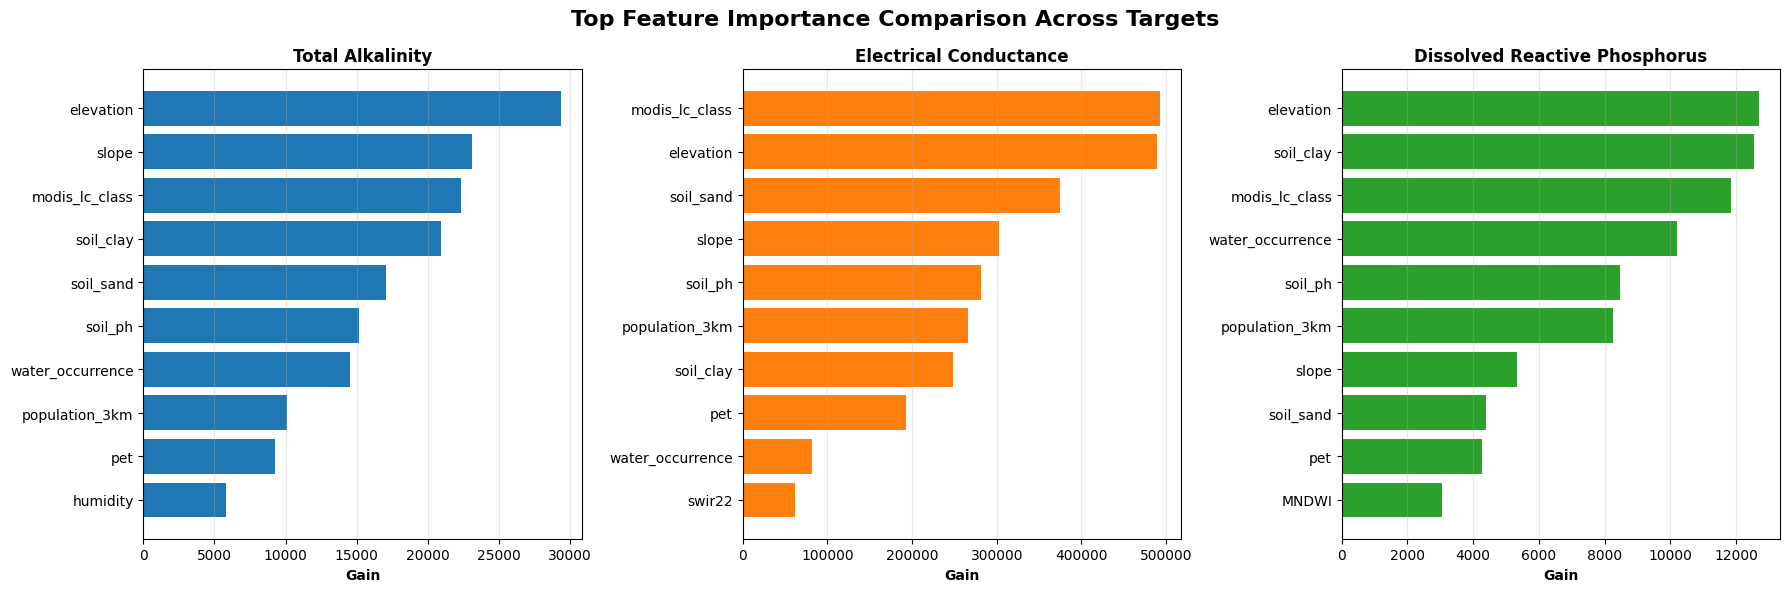

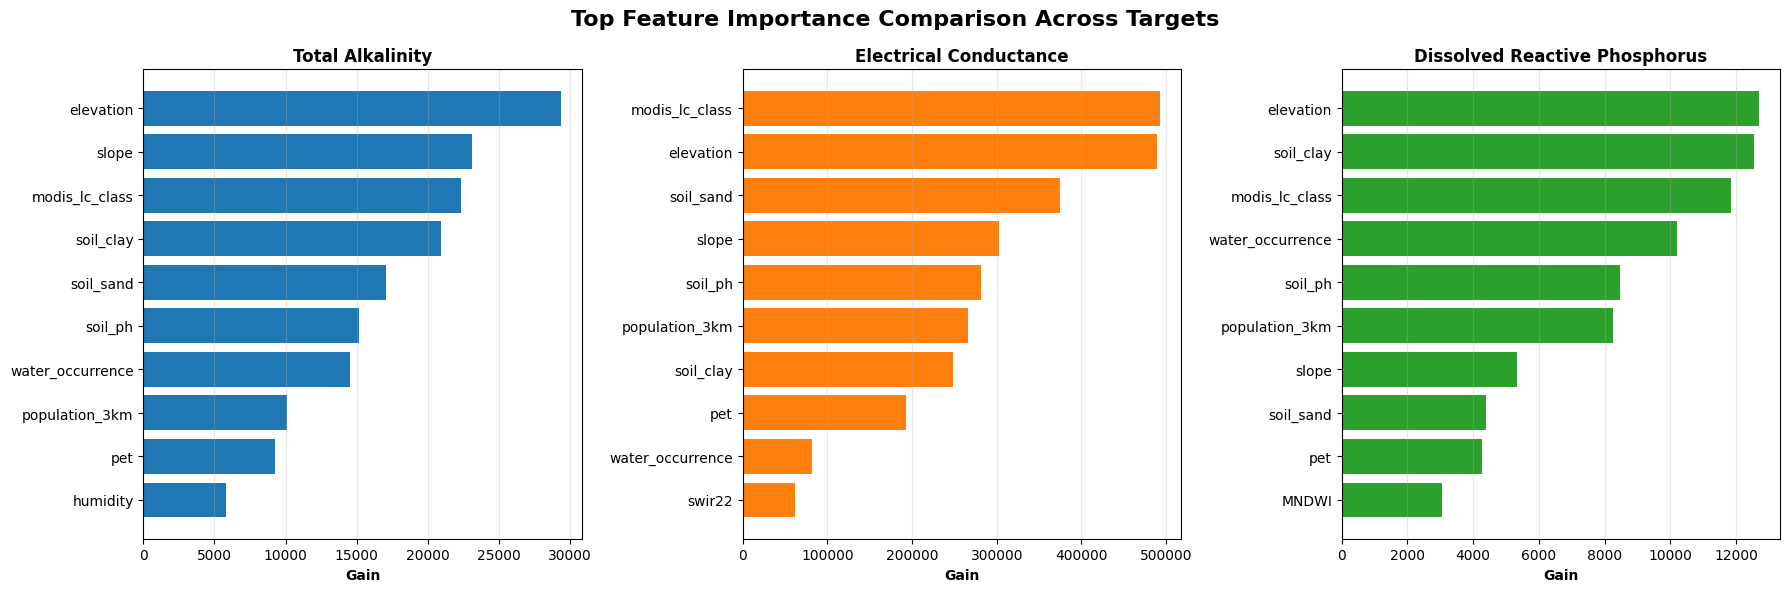

In [395]:
def compare_feature_importance(models, names, feature_names, top_n=10):
    """Compare top features across all three models."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Top Feature Importance Comparison Across Targets', 
                 fontsize=16, fontweight='bold')
    
    for idx, (model, name, ax) in enumerate(zip(models, names, axes)):
        importance_gain = model.get_booster().get_score(importance_type='gain')
        
        # Map feature indices to names
        feature_map = {f'f{i}': fname for i, fname in enumerate(feature_names)}
        imp_df = pd.DataFrame({
            'Feature': [feature_map.get(k, k) for k in importance_gain.keys()],
            'Importance': list(importance_gain.values())
        }).sort_values('Importance', ascending=True).tail(top_n)
        
        ax.barh(imp_df['Feature'], imp_df['Importance'], color=f'C{idx}')
        ax.set_xlabel('Gain', fontweight='bold')
        ax.set_title(name, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Compare feature importance
compare_feature_importance(
    models=[model_TA, model_EC, model_DRP],
    names=['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus'],
    feature_names=X.columns.tolist(),
    top_n=10
)
